In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import matplotlib.pyplot as plt

In [21]:
data_rnn = pd.read_csv("https://raw.githubusercontent.com/t0ccata/final-project-ml/main/archive/daily/AALI.csv")
data_rnn['timestamp'] = pd.to_datetime(data_rnn['timestamp'])
data_rnn.set_index('timestamp', inplace=True)
data_rnn.head()

,open,low,high,close,volume
timestamp,,,,,
2001-04-16,524,524,547,547,342131
2001-04-17,547,524,571,524,345804
2001-04-18,547,524,547,524,230361
2001-04-19,524,500,524,500,457574
2001-04-20,476,452,476,452,228262


In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_rnn)

In [25]:
def create_sequences(data_rnn, seq_length):
    sequences, targets = [], []
    for i in range(len(data_rnn) - seq_length):
        sequences.append(data_rnn[i:i + seq_length])
        targets.append(data_rnn[i + seq_length, 3])  # Close price is the target
    return np.array(sequences), np.array(targets)

In [26]:
seq_length = 60
sequences, targets = create_sequences(scaled_data, seq_length)

In [27]:
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

In [28]:
model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(seq_length, 5)),
    Dropout(0.2),
    SimpleRNN(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

In [29]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 60, 50)            2800      
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7901 (30.86 KB)
Trainable params: 7901 (30.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
141/141 [==============================] - 7s 35ms/step - loss: 0.0555 - val_loss: 8.3057e-04
Epoch 2/10
141/141 [==============================] - 5s 36ms/step - loss: 0.0119 - val_loss: 3.5791e-04
Epoch 3/10
141/141 [==============================] - 4s 29ms/step - loss: 0.0074 - val_loss: 4.1443e-04
Epoch 4/10
141/141 [==============================] - 5s 35ms/step - loss: 0.0051 - val_loss: 1.1396e-04
Epoch 5/10
141/141 [==============================] - 5s 33ms/step - loss: 0.0041 - val_loss: 1.8756e-04
Epoch 6/10
141/141 [==============================] - 4s 29ms/step - loss: 0.0035 - val_loss: 2.2936e-04
Epoch 7/10
141/141 [==============================] - 5s 37ms/step - loss: 0.0030 - val_loss: 9.7034e-05
Epoch 8/10
141/141 [==============================] - 5s 32ms/step - loss: 0.0026 - val_loss: 1.0984e-04
Epoch 9/10
141/141 [==============================] - 4s 29ms/step - loss: 0.0025 - val_loss: 1.6310e-04
Epoch 10/10
141/141 [==============================] - 

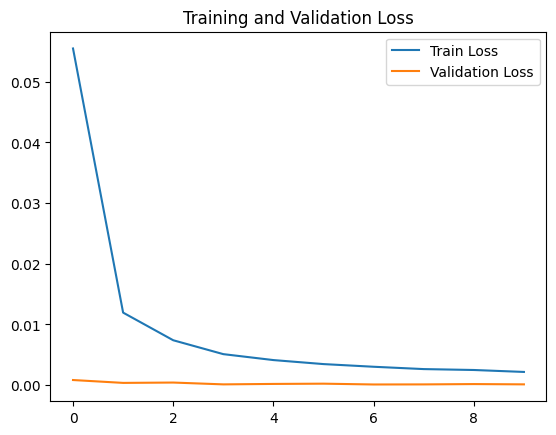

In [31]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [32]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

36/36 [==============================] - 0s 9ms/step


In [33]:
combined_train_test_predictions = np.concatenate((train_predictions, test_predictions), axis=0)
combined_train_test_actual = np.concatenate((y_train, y_test), axis=0)

In [34]:
mse_normalized = mean_squared_error(combined_train_test_actual, combined_train_test_predictions)
mape_normalized = mean_absolute_percentage_error(combined_train_test_actual, combined_train_test_predictions)
r2_normalized = r2_score(combined_train_test_actual, combined_train_test_predictions)

print(f'Normalized Data Metrics:')
print(f'MSE: {mse_normalized}')
print(f'MAPE: {mape_normalized}')
print(f'R2 Score: {r2_normalized}')

Normalized Data Metrics:
MSE: 0.0003389386555673803
MAPE: 0.055967443990214076
R2 Score: 0.9938848393231734


In [35]:
def inverse_transform_predictions(predictions, data_scaler, index=3):
    dummy_data = np.zeros((predictions.shape[0], data_scaler.n_features_in_))
    dummy_data[:, index] = predictions[:, 0]
    return data_scaler.inverse_transform(dummy_data)[:, index]

train_predictions_denormalized = inverse_transform_predictions(train_predictions, scaler)
test_predictions_denormalized = inverse_transform_predictions(test_predictions, scaler)

In [36]:
y_train_denormalized = inverse_transform_predictions(y_train.reshape(-1, 1), scaler)
y_test_denormalized = inverse_transform_predictions(y_test.reshape(-1, 1), scaler)

In [37]:
mse_denormalized = mean_squared_error(y_test_denormalized, test_predictions_denormalized)
mape_denormalized = mean_absolute_percentage_error(y_test_denormalized, test_predictions_denormalized)
r2_denormalized = r2_score(y_test_denormalized, test_predictions_denormalized)

print(f'Denormalized Data Metrics:')
print(f'MSE: {mse_denormalized}')
print(f'MAPE: {mape_denormalized}')
print(f'R2 Score: {r2_denormalized}')

Denormalized Data Metrics:
MSE: 118944.83264274693
MAPE: 0.025976297520861537
R2 Score: 0.9643938888660394


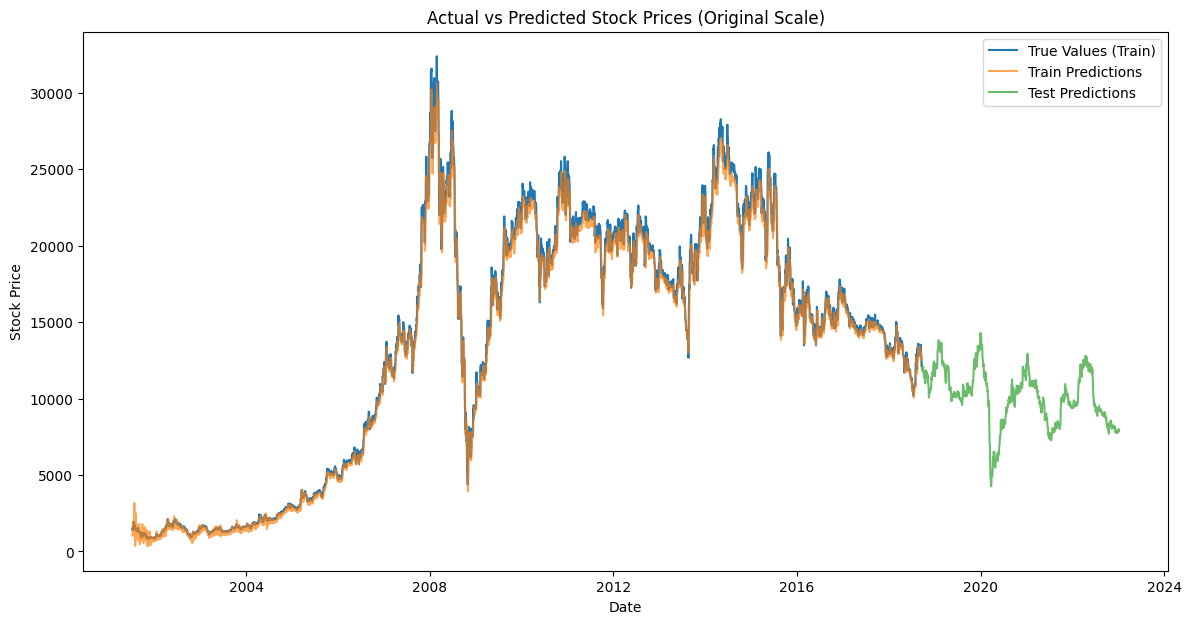

In [39]:
plt.figure(figsize=(14, 7))
plt.plot(data_rnn.index[seq_length:seq_length+len(y_train_denormalized)], y_train_denormalized, label='True Values (Train)')
plt.plot(data_rnn.index[seq_length:seq_length+len(train_predictions_denormalized)], train_predictions_denormalized, label='Train Predictions', alpha=0.7)
plt.plot(data_rnn.index[seq_length+len(train_predictions_denormalized):seq_length+len(train_predictions_denormalized)+len(test_predictions_denormalized)], test_predictions_denormalized, label='Test Predictions', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Stock Prices (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

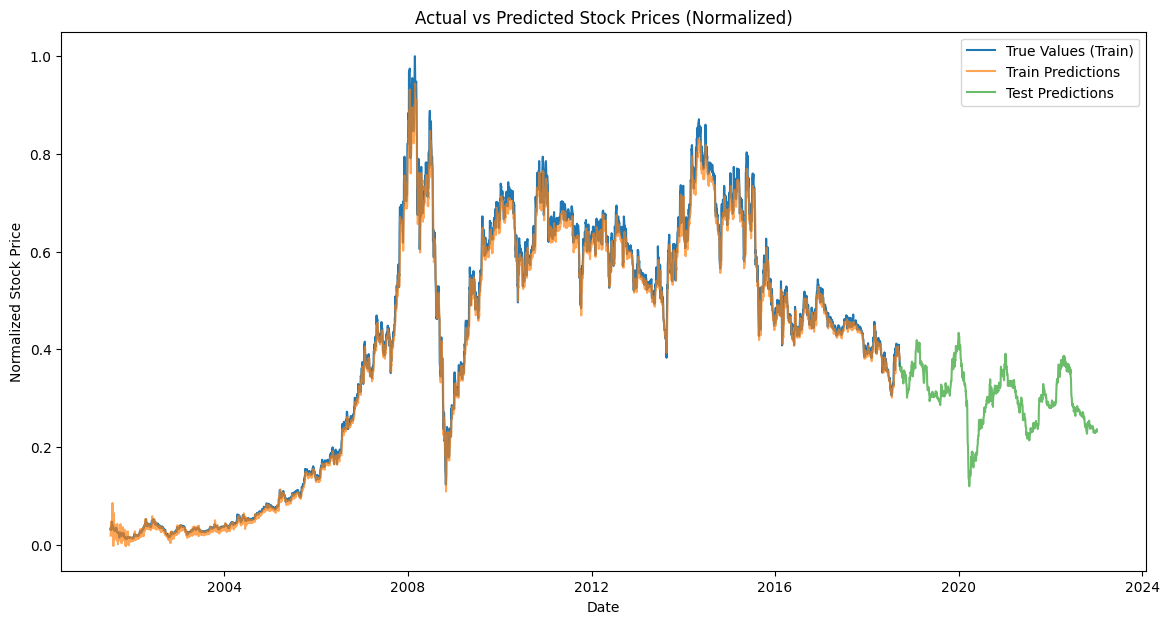

In [40]:
plt.figure(figsize=(14, 7))
plt.plot(data_rnn.index[seq_length:seq_length + len(y_train)], y_train, label='True Values (Train)')
plt.plot(data_rnn.index[seq_length:seq_length + len(train_predictions)], combined_train_test_predictions[:len(train_predictions)], label='Train Predictions', alpha=0.7)
plt.plot(data_rnn.index[seq_length + len(train_predictions):seq_length + len(train_predictions) + len(test_predictions)], combined_train_test_predictions[len(train_predictions):], label='Test Predictions', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Stock Prices (Normalized)')
plt.xlabel('Date')
plt.ylabel('Normalized Stock Price')
plt.show()